In [9]:
import os
import sys

sys.path.append('/Users/fllorente/Dropbox/con_Petar/PYTHON/gp_fusion')

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import numpyro
from numpyro.infer import NUTS, MCMC, SVI, Trace_ELBO, Predictive
from numpyro.infer.autoguide import AutoDelta, AutoNormal

from optax import adam, chain, clip

from numpyro import distributions as dist
import jax
import jax.numpy as jnp
import jax.random as random

numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)
numpyro.enable_x64()


from uci_datasets import Dataset


from modules.data_handling import load_data  # Same as using Dataset but X and Y have std dv = 1 column-wise


In [10]:
dataset_names = ["autos", 'housing','stock','sml',
                 'elevators','breastcancer','forest','gas',
                 ]


dataset_name = dataset_names[1]
full_dataset = Dataset(dataset_name)
N,DIM = full_dataset.x.shape

housing dataset, N=506, d=13


In [11]:
# load_data uses the normalized dataset, i.e., full_dataset.x and full_dataset.y have unit variance
split = 0
X_train,y_train,X_test,y_test,_ = load_data(dataset_name,split)

# OG RFF-Pogpe (with learning of weights)

In [12]:

def og_pogpe(X, M=None, S = 50, Y=None, y_test=None):              # M is the number of experts
    N = X.shape[0]
    DIM = X.shape[1]
    
    Omega_fixed = jax.random.normal(jax.random.PRNGKey(30), (S, DIM)) # S is the number of spectral freqs

    #########################
    # RF-GP for the experts #
    #########################
    with numpyro.plate("M", M, dim=-2):
        var_mu_ex = numpyro.sample("kernel_var_exp_mean", dist.HalfNormal(1.0))
        # noise_mu_ex = numpyro.sample("kernel_noise_exp_mean", dist.InverseGamma(5.0, 5.0))
        std_ex_un = numpyro.sample('std_ex_un', dist.InverseGamma(5.0, 5.0))
        std_ex = numpyro.deterministic('std_ex', jnp.tile(jnp.reshape(std_ex_un, (-1, 1)), N))

        with numpyro.plate('2S', 2*S):
            theta_mu_ex = numpyro.sample("theta_mu_ex", dist.Normal(loc=0.0, 
                                                        scale=1.0)) # I'm not considering signal power here!
            
        with  numpyro.plate('DIM', DIM):
            lengthscale_ex = numpyro.sample('ell_ex', dist.HalfNormal(scale = 10.0))

            
    assert lengthscale_ex.shape == (M,DIM)
    assert Omega_fixed.shape == (S,DIM)

    #### OMEGA FIXED
    vdivide =  jax.vmap(lambda x, y: jnp.divide(x, y), (None, 0))      
    matmul_vmapped = jax.vmap(lambda A,B: (A @ B).squeeze(), in_axes=(0, 0))                                                                                                                      
    Omega_ex = vdivide( Omega_fixed, lengthscale_ex)     # shape = (M,S,DIM)
    ########
    assert Omega_ex.shape == (M,S,DIM)
    ola = X @ jnp.transpose(Omega_ex, axes=(0,2,1))     # this is batch matmul: (Ndata,DIM) x (M,DIM,S) = (M,Ndata,S)
    #assert ola.shape == (M,N,S)
    Phi_ex = jnp.concatenate([jnp.sin(ola), jnp.cos(ola)], axis=2)  # tiene shape = (M, Ndata, 2*S)
    Phi_ex = 1/jnp.sqrt(S)*Phi_ex  # se me habia olvidado dividir entre jnp.sqrt(S)
    assert Phi_ex.shape == (M, N, 2*S)
    assert std_ex.shape == (M,N)
    assert theta_mu_ex.shape == (M,2*S)

    # theta_mu_ex = jnp.tile(jnp.sqrt(var_mu_ex+ noise_mu_ex),2*S) * theta_mu_ex
    theta_mu_ex = jnp.tile(jnp.sqrt(var_mu_ex),2*S) * theta_mu_ex
    mu_ex = numpyro.deterministic("mu_ex", matmul_vmapped(Phi_ex,theta_mu_ex) )                 # shape = (M,Ndata)
    assert mu_ex.shape == (M,N)



    #########################
    # RF-GP for log weights #
    #########################
    with numpyro.plate("M", M, dim=-2):
        # set uninformative log-normal priors on our three kernel hyperparameters
        var_logw = numpyro.sample("kernel_var_logw", dist.HalfNormal(1.0))
        # noise_logw = numpyro.sample("kernel_noise_logw", dist.InverseGamma(5.0, 5.0))

        with numpyro.plate('2S', 2*S):
            theta_logw = numpyro.sample("theta_logw", dist.Normal(loc=0.0, 
                                                        scale=1.0)) # I'm not considering signal power here!
            
        with numpyro.plate("DIM", DIM):
            lengthscale_logw = numpyro.sample('ell_logw', dist.HalfNormal(scale = 10.0))

    assert lengthscale_logw.shape == (M,DIM)

    # theta_logw = jnp.tile(jnp.sqrt(var_logw+ noise_logw),2*S) * theta_logw
    theta_logw = jnp.tile(jnp.sqrt(var_logw),2*S) * theta_logw
    assert theta_logw.shape == (M,2*S)


    Omega_logw = vdivide( Omega_fixed, lengthscale_logw)     # shape = (M,S,DIM)
    ola = X @ jnp.transpose(Omega_logw, axes=(0,2,1))     # this is batch matmul: (Ndata,DIM) x (M,DIM,S) = (M,Ndata,S)

    Phi_logw = jnp.concatenate([jnp.sin(ola), jnp.cos(ola)], axis=2)  # tiene shape = (M, Ndata, 2*S)
    Phi_logw = 1/jnp.sqrt(S)*Phi_logw  # se me habia olvidado dividir entre jnp.sqrt(S)

    logw = numpyro.deterministic("logw", matmul_vmapped(Phi_logw, theta_logw) - jnp.log(M))   # PRIOR MEAN FUNCTION!
    assert logw.shape == (M,N)


    ################################################
    # Fuse with generalized multiplicative pooling #
    ################################################
    w = numpyro.deterministic("w", jnp.exp(logw) )                 # shape = (M,Ndata)
    # w = numpyro.deterministic("w", jnp.ones((M,N)))  # All weights are one (not trained)
    # w  = w.T
    tau_ex = 1. / std_ex

    assert w.shape == (M,N)
    tau_fused = numpyro.deterministic(
        "tau_fused", 
        # jnp.einsum("nm,mn->m", tau_ex, w),
        jnp.sum(tau_ex*w,axis=0).squeeze()
    )  # N,
    assert tau_fused.shape == (N,)

    mu_fused = numpyro.deterministic(
        "mean_fused", 
        # jnp.einsum("nm,nm,mn->m", tau_ex, mu_ex, w) / tau_fused,
        jnp.sum(tau_ex*mu_ex*w,axis=0).squeeze()/tau_fused
    )  # N,
    assert mu_fused.shape == (N,)
    
    std_fused = numpyro.deterministic("std_fused", 1 / jnp.sqrt(tau_fused))
    assert std_fused.shape == (N,)

    # noise = numpyro.sample("noise", dist.HalfNormal(scale = 1))

    Y = jnp.squeeze(Y)
    numpyro.sample(
        "y_val",
        dist.Normal(loc=mu_fused, 
                    scale=std_fused,
                    # scale=jnp.sqrt(jnp.squeeze(std_fused)**2 + noise),
                    ),
        obs=Y,
    )

    if y_test is not None:
        # compute the lpd of the observations
        numpyro.deterministic("lpd_point", jax.scipy.stats.norm.logpdf(
                jnp.squeeze(y_test), loc=jnp.squeeze(mu_fused), scale=jnp.squeeze(std_fused),
                )
            )

In [13]:
def train_and_predict_joint(model, num_experts, num_spectral_freqs, data_dict, 
                            guide_svi = None,
                            training_iter = 500, lr = 0.1,
                            **kwargs):
    guide = guide_svi or AutoDelta(model, 
                    init_loc_fn = numpyro.infer.initialization.init_to_median,
                    # init_loc_fn = numpyro.infer.initialization.init_to_uniform,
                    # init_loc_fn = numpyro.infer.init_to_sample,
                    )
    svi= SVI(model,
            guide,
            # optim = numpyro.optim.Minimize(),  # Using lbfgs instead of adam
            # optim=chain(clip(10.0), adam(0.005)),
            optim = numpyro.optim.Adam(lr),
            loss=Trace_ELBO(num_particles=10),   # default is 1
        )


    res = svi.run(
        jax.random.PRNGKey(30),
        training_iter,  
        X=data_dict["X_train"],
        Y=data_dict["y_train"],
        M=num_experts,
        S=num_spectral_freqs,
        **kwargs,
    )


    params = res.params

    # First option (it doesn't work...)
    # posterior_samples = guide.sample_posterior(random.PRNGKey(1), params, (100,) )
    # dist_posterior_predictive = Predictive(model=model, 
    #                                        guide=guide, 
    #                                        params=params, 
    #                                        posterior_samples=posterior_samples,)

    # Another option:
    predictive = Predictive(guide, params=params, num_samples=100)
    posterior_samples = predictive(random.PRNGKey(3),
                                   X=data_dict["X_train"], 
                                   Y=data_dict["y_train"], 
                                   M=num_experts,
                                   S=num_spectral_freqs,
                                    y_test=data_dict["y_train"],
                                    **kwargs,)  # these are samples from the guide! See https://github.com/pyro-ppl/numpyro/issues/1309
    dist_posterior_predictive = Predictive(model,posterior_samples)

    # BEST option:
    # dist_posterior_predictive = Predictive(model=model,guide=guide, params=params, num_samples=100)

    # when using AutoDelta, these are not actual samples but just the MAP estimates 
    # TRAINING DATA
    samples_tr = dist_posterior_predictive(jax.random.PRNGKey(3), 
                                        X=data_dict["X_train"], 
                                        Y=data_dict["y_train"], 
                                        M=num_experts,
                                        S=num_spectral_freqs,
                                        y_test=data_dict["y_train"],
                                        **kwargs,
                                        )

    ymu_tr = samples_tr["mean_fused"].mean(0)
    ys_tr = samples_tr["std_fused"].mean(0)
    w_tr = samples_tr["w"].mean(0)

    nlpd_train = - jnp.mean(
        jax.nn.logsumexp(samples_tr["lpd_point"], axis=0) - jnp.log(samples_tr["lpd_point"].shape[0])
    )
    rmse_train = np.sqrt(np.mean((ymu_tr.squeeze()-data_dict["y_train"].squeeze())**2))

    # TEST DATA
    samples_tst = dist_posterior_predictive(jax.random.PRNGKey(3), 
                                        X=data_dict["X_test"], 
                                        Y=data_dict["y_test"], 
                                        M=num_experts,
                                        S=num_spectral_freqs,
                                        y_test=data_dict["y_test"],
                                        **kwargs,
                                        )

    ymu_tst = samples_tst["mean_fused"].mean(0)
    ys_tst = samples_tst["std_fused"].mean(0)
    w_tst = samples_tst["w"].mean(0)

    nlpd_test = - jnp.mean(
        jax.nn.logsumexp(samples_tst["lpd_point"], axis=0) - jnp.log(samples_tst["lpd_point"].shape[0])
    )
    rmse_test = np.sqrt(np.mean((ymu_tst.squeeze()-data_dict["y_test"].squeeze())**2))


    return nlpd_test, rmse_test, nlpd_train, rmse_train, samples_tst, samples_tr, res

In [14]:
num_experts = 2
num_spectral_freqs = 100
model = og_pogpe

# map estimates
nlpd_test, rmse_test, nlpd_train, rmse_train, samples_tst, samples_tr,_ = train_and_predict_joint(
    model=model, num_experts=num_experts, num_spectral_freqs=num_spectral_freqs, 
    data_dict={"X_train": X_train, "y_train": y_train, "X_test": X_test, "y_test": y_test},
    training_iter=3000, lr= 0.1,
)


print("nlpd train: ", nlpd_train)
print("nlpd test: ", nlpd_test)

print("rmse train: ", rmse_train)
print("rmse test: ", rmse_test)

100%|██████████| 3000/3000 [00:07<00:00, 375.22it/s, init loss: 1595.1310, avg. loss [2851-3000]: 802.9873] 


nlpd train:  -0.49764063047987983
nlpd test:  7.283281873987339
rmse train:  0.17732504126931245
rmse test:  0.40397819433537613


In [8]:
_.params["kernel_var_exp_mean_auto_loc"].shape

(5, 1)

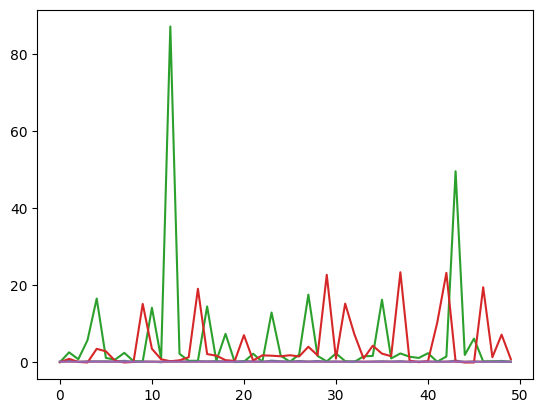

In [307]:
for i in range(num_experts):
    plt.plot(samples_tst["w"].mean(0)[i,:])

In [308]:
# Variational Gaussian approx
model = og_pogpe

nlpd_test, rmse_test, nlpd_train, rmse_train, samples_tst, samples_tr,_ = train_and_predict_joint(
    model=model, num_experts=num_experts, num_spectral_freqs=num_spectral_freqs, 
    data_dict={"X_train": X_train, "y_train": y_train, "X_test": X_test, "y_test": y_test},
    # ------
    guide_svi= AutoNormal(model, init_loc_fn = numpyro.infer.init_to_sample),
    # ------
    training_iter=3000, 
    lr= 1e-2,
)


print("nlpd train: ", nlpd_train)
print("nlpd test: ", nlpd_test)

print("rmse train: ", rmse_train)
print("rmse test: ", rmse_test)

100%|██████████| 3000/3000 [02:20<00:00, 21.28it/s, init loss: 5837.8836, avg. loss [2851-3000]: 406.4039]


nlpd train:  0.4003418782958092
nlpd test:  0.4594325520959797
rmse train:  0.38748548124492393
rmse test:  0.4523011225344433


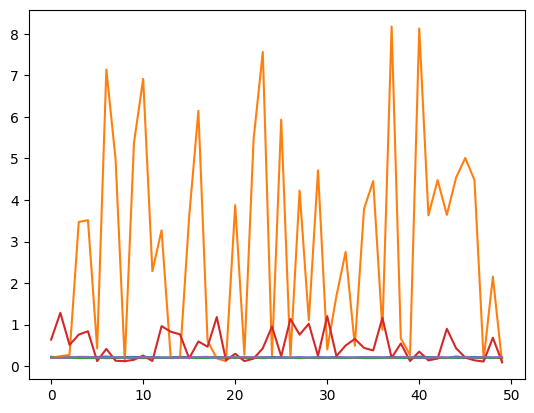

In [309]:
for i in range(num_experts):
    plt.plot(samples_tst["w"].mean(0)[i,:])

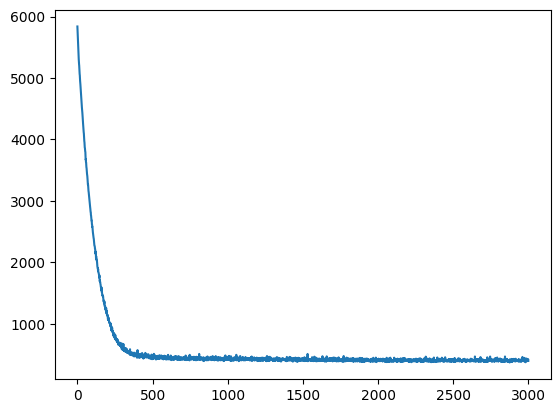

In [310]:
plt.plot(_[2])

## Average over all splits

In [301]:
num_experts = 5
num_spectral_freqs = 100
model = og_pogpe


nlpd = []
rmse = []

for split in tqdm(range(10)):

    X_train,y_train,X_test,y_test,_ = load_data(dataset_name,split)

    # map estimates
    nlpd_test, rmse_test, nlpd_train, rmse_train, samples_tst, samples_tr,_ = train_and_predict_joint(
        model=model, num_experts=num_experts, num_spectral_freqs=num_spectral_freqs, 
        data_dict={"X_train": X_train, "y_train": y_train, "X_test": X_test, "y_test": y_test},
        training_iter=3000, lr= 0.1,
    )

    nlpd.append(nlpd_test)
    rmse.append(rmse_test)

nlpd = np.array(nlpd)
rmse = np.array(rmse)

100%|██████████| 10/10 [03:10<00:00, 19.05s/it]


In [302]:
print(f"{'og pogpe':<15} nlpd: {nlpd.mean():.2f} ± {nlpd.std()/np.sqrt(10):.2f}, rmse: {rmse.mean():.2f} ± {rmse.std()/np.sqrt(10):.2f}")


og pogpe        nlpd: 3.52 ± 0.74, rmse: 0.75 ± 0.05


# RFF-Pogpe with fixed weights

In order to avoid having constant predictive variance, we also model the experts (log) variances as GPs,
as in Tresp (2000) "Mixture of Gaussian processes"

In [207]:
def pogpe_with_fixed_w(X, M=None, S = 50, Y=None, y_test=None):              # M is the number of experts
    N = X.shape[0]
    DIM = X.shape[1]
    
    Omega_fixed = jax.random.normal(jax.random.PRNGKey(30), (S, DIM))

    assert Omega_fixed.shape == (S,DIM)

    #########################
    # RF-GP for the experts #
    #########################
    with numpyro.plate("M", M, dim=-2):
        var_mu_ex = numpyro.sample("kernel_var_exp_mean", dist.HalfNormal(1.0))
        var_logstd_ex = numpyro.sample("kernel_var_exp_logstd", dist.HalfNormal(1.0))

        with numpyro.plate('2S', 2*S):
            theta_mu_ex = numpyro.sample("theta_mu_ex", dist.Normal(loc=0.0, 
                                                        scale=1.0)) # I'm not considering signal power here!
            theta_logstd_ex = numpyro.sample("theta_logstd_ex", dist.Normal(loc=0.0, 
                                                        scale=1.0)) # I'm not considering signal power here!
            
        with  numpyro.plate('DIM', DIM):
            lengthscale_mu_ex = numpyro.sample('ell_ex', dist.HalfNormal(scale = 100.0))
            lengthscale_logstd_ex = numpyro.sample('ell_logstd_ex', dist.HalfNormal(scale = 100.0))

            
    assert lengthscale_mu_ex.shape == (M,DIM)
    assert lengthscale_logstd_ex.shape == (M,DIM)
    assert theta_mu_ex.shape == (M,2*S)
    assert theta_logstd_ex.shape == (M,2*S)

    #### OMEGA FIXED
    vdivide =  jax.vmap(lambda x, y: jnp.divide(x, y), (None, 0))    
    matmul_vmapped = jax.vmap(lambda A,B: (A @ B).squeeze(), in_axes=(0, 0))   
    #
    # =============== EXPERTS' MEANS  =============== #                                                                                                                   
    Omega_mu_ex = vdivide( Omega_fixed, lengthscale_mu_ex)     # shape = (M,S,DIM)
    assert Omega_mu_ex.shape == (M,S,DIM)
    ola = X @ jnp.transpose(Omega_mu_ex, axes=(0,2,1))     # this is batch matmul: (Ndata,DIM) x (M,DIM,S) = (M,Ndata,S)
    #assert ola.shape == (M,N,S)
    Phi_mu_ex = jnp.concatenate([jnp.sin(ola), jnp.cos(ola)], axis=2)  # tiene shape = (M, Ndata, 2*S)
    Phi_mu_ex = 1/jnp.sqrt(S)*Phi_mu_ex  # se me habia olvidado dividir entre jnp.sqrt(S)
    assert Phi_mu_ex.shape == (M, N, 2*S)
    #
    theta_mu_ex = jnp.tile(jnp.sqrt(var_mu_ex),2*S) * theta_mu_ex
    mu_ex = numpyro.deterministic("mu_ex", matmul_vmapped(Phi_mu_ex,theta_mu_ex) )    
    assert mu_ex.shape == (M,N)
    # ========================================== #

    # =============== EXPERTS' LOGSTDS  =============== #                                                                                                                   
    Omega_logstd_ex = vdivide( Omega_fixed, lengthscale_logstd_ex)     # shape = (M,S,DIM)
    assert Omega_logstd_ex.shape == (M,S,DIM)
    ola = X @ jnp.transpose(Omega_logstd_ex, axes=(0,2,1))     # this is batch matmul: (Ndata,DIM) x (M,DIM,S) = (M,Ndata,S)
    #assert ola.shape == (M,N,S)
    Phi_logstd_ex = jnp.concatenate([jnp.sin(ola), jnp.cos(ola)], axis=2)  # tiene shape = (M, Ndata, 2*S)
    Phi_logstd_ex = 1/jnp.sqrt(S)*Phi_logstd_ex  # se me habia olvidado dividir entre jnp.sqrt(S)
    assert Phi_logstd_ex.shape == (M, N, 2*S)
    #
    theta_logstd_ex = jnp.tile(jnp.sqrt(var_logstd_ex),2*S) * theta_logstd_ex
    logstd_ex = numpyro.deterministic("logstd_ex", matmul_vmapped(Phi_logstd_ex,theta_logstd_ex) )   
    std_ex =  numpyro.deterministic("std_ex", jnp.exp(logstd_ex) )
    assert logstd_ex.shape == (M,N)
    assert std_ex.shape == (M,N)
    # ========================================== #



    ################################################
    # Fuse with generalized multiplicative pooling #
    ################################################
    # w needs to have shape = (M,Ndata)     
    # w = numpyro.deterministic("w", jnp.ones((M,N)))  # All weights are one (not trained)
    w = numpyro.deterministic("w", jnp.ones((M,N))/M)  # All weights are uniform (not trained)
    w  = w.T
    tau_ex = 1. / std_ex


    tau_fused = numpyro.deterministic(
        "tau_fused", jnp.einsum("nm,mn->m", tau_ex, w)
    )  # N,
    assert tau_fused.shape == (N,)

    mu_fused = numpyro.deterministic(
        "mean_fused", jnp.einsum("nm,nm,mn->m", tau_ex, mu_ex, w) / tau_fused
    )  # N,
    assert mu_fused.shape == (N,)
    
    std_fused = numpyro.deterministic("std_fused", 1 / jnp.sqrt(tau_fused))
    assert std_fused.shape == (N,)

    # noise = numpyro.sample("noise", dist.HalfNormal(scale = 1))

    numpyro.sample(
        "y_val",
        dist.Normal(loc=jnp.squeeze(mu_fused), 
                    scale=jnp.squeeze(std_fused),
                    # scale=jnp.sqrt(jnp.squeeze(std_fused)**2 + noise),
                    ),
        obs=Y,
    )

    if y_test is not None:
        # compute the lpd of the observations
        numpyro.deterministic("lpd_point", jax.scipy.stats.norm.logpdf(
                jnp.squeeze(y_test), loc=jnp.squeeze(mu_fused), scale=jnp.squeeze(std_fused),
                )
            )

In [96]:
num_experts = 5
num_spectral_freqs = 100
model = pogpe_with_fixed_w

# map estimates
nlpd_test, rmse_test, nlpd_train, rmse_train, samples_tst, samples_tr,_ = train_and_predict_joint(
    model=model, num_experts=num_experts, num_spectral_freqs=num_spectral_freqs, 
    data_dict={"X_train": X_train, "y_train": y_train, "X_test": X_test, "y_test": y_test},
    training_iter=3000, lr= 0.1,
)


print("nlpd train: ", nlpd_train)
print("nlpd test: ", nlpd_test)

print("rmse train: ", rmse_train)
print("rmse test: ", rmse_test)

100%|██████████| 3000/3000 [00:10<00:00, 275.04it/s, init loss: 3753.1170, avg. loss [2851-3000]: 2133.0504]


nlpd train:  -0.4546952324354771
nlpd test:  2.4610883503040535
rmse train:  0.23369667294284657
rmse test:  0.2750069699979428


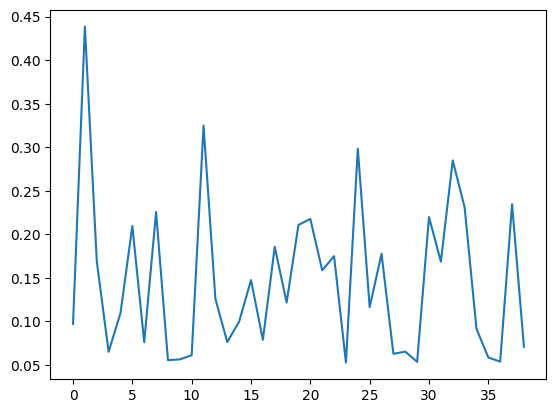

In [97]:
plt.plot(samples_tst["std_fused"].mean(0))

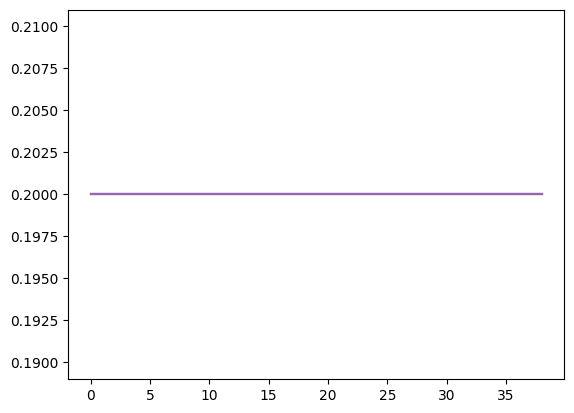

In [98]:
for i in range(num_experts):
    plt.plot(samples_tst["w"].mean(0)[i,:])

In [99]:
# Variational Gaussian approx
model = pogpe_with_fixed_w

nlpd_test, rmse_test, nlpd_train, rmse_train, samples_tst, samples_tr,_ = train_and_predict_joint(
    model=model, num_experts=num_experts, num_spectral_freqs=num_spectral_freqs, 
    data_dict={"X_train": X_train, "y_train": y_train, "X_test": X_test, "y_test": y_test},
    # ------
    guide_svi= AutoNormal(model, init_loc_fn = numpyro.infer.init_to_sample),
    # ------
    training_iter=3000, lr= 0.1,
)


print("nlpd train: ", nlpd_train)
print("nlpd test: ", nlpd_test)

print("rmse train: ", rmse_train)
print("rmse test: ", rmse_test)

100%|██████████| 3000/3000 [00:08<00:00, 338.43it/s, init loss: 5300.9849, avg. loss [2851-3000]: 565.7909] 


nlpd train:  0.7072973475428633
nlpd test:  0.6268051834193797
rmse train:  0.41654961534845053
rmse test:  0.36625726073700515


## Average over all splits

In [52]:
num_experts = 5
num_spectral_freqs = 100
model = pogpe_with_fixed_w


nlpd = []
rmse = []

for split in tqdm(range(10)):

    X_train,y_train,X_test,y_test,_ = load_data(dataset_name,split)

    # map estimates
    nlpd_test, rmse_test, nlpd_train, rmse_train, samples_tst, samples_tr,_ = train_and_predict_joint(
        model=model, num_experts=num_experts, num_spectral_freqs=num_spectral_freqs, 
        data_dict={"X_train": X_train, "y_train": y_train, "X_test": X_test, "y_test": y_test},
        training_iter=3000, lr= 0.1,
    )

    nlpd.append(nlpd_test)
    rmse.append(rmse_test)

100%|██████████| 10/10 [02:05<00:00, 12.52s/it]


AttributeError: 'list' object has no attribute 'mean'

In [56]:
nlpd = np.array(nlpd)
rmse = np.array(rmse)

print(f"{'pogpe with fixed w':<15} nlpd: {nlpd.mean():.2f} ± {nlpd.std()/np.sqrt(10):.2f}, rmse: {rmse.mean():.2f} ± {rmse.std()/np.sqrt(10):.2f}")


pogpe with fixed w nlpd: 1.91 ± 0.59, rmse: 0.40 ± 0.02


# RFF-Pogpe with random projs

In [15]:
def pogpe_with_projs(X, M, proj_dim, S = 50, Y=None, y_test=None, normalize_weights = True):        
    # Auxiliary functions    
    vdivide =  jax.vmap(lambda x, y: jnp.divide(x, y), (None, 0))    
    matmul_vmapped = jax.vmap(lambda A,B: (A @ B).squeeze(), in_axes=(0, 0)) 

    N = X.shape[0]
    DIM = X.shape[1]
    
    Omega_fixed = jax.random.normal(jax.random.PRNGKey(30), (S, proj_dim))
    assert Omega_fixed.shape == (S,proj_dim)

    X_reps = jnp.tile(jnp.expand_dims(X,0), (M,1,1))
    assert X_reps.shape == (M,N,DIM)

    P_projs = jax.random.normal(jax.random.PRNGKey(42), (M,DIM, proj_dim))/jnp.sqrt(proj_dim)   

    with numpyro.plate("DIM", DIM):
        ell = numpyro.sample("lengthscales", dist.HalfNormal(1.0)) + 1e-3

    assert ell.shape == (DIM,)
    X_projs = matmul_vmapped(X_reps, P_projs / ell[None, :, None])
    assert (ell[None, :, None] * P_projs).shape == P_projs.shape
    assert X_projs.shape == (M,N,proj_dim)
    #########################
    # RF-GP for the experts #
    #########################
    with numpyro.plate("M", M, dim=-2):
        var_mu_ex = numpyro.sample("kernel_var_exp_mean", dist.HalfNormal(1.0))
        var_logstd_ex = numpyro.sample("kernel_var_exp_logstd", dist.HalfNormal(1.0))
        # w_ex = numpyro.sample("w_ex", dist.HalfNormal(scale=1.0)) # we learn a unique weight for each expert
        w_ex = numpyro.sample("w_ex", dist.Normal(loc=0.0, scale=1.0)) # we learn a unique weight for each expert

        with numpyro.plate('2S', 2*S):
            theta_mu_ex = numpyro.sample("theta_mu_ex", dist.Normal(loc=0.0, 
                                                        scale=1.0)) # I'm not considering signal power here!
            theta_logstd_ex = numpyro.sample("theta_logstd_ex", dist.Normal(loc=0.0, 
                                                        scale=1.0)) # I'm not considering signal power here!
            
        with  numpyro.plate('proj_dim', proj_dim):
            lengthscale_mu_ex = numpyro.sample('ell_ex', dist.HalfNormal(scale = 100.0))
            lengthscale_logstd_ex = numpyro.sample('ell_logstd_ex', dist.HalfNormal(scale = 100.0))

            
    assert lengthscale_mu_ex.shape == (M,proj_dim)
    assert lengthscale_logstd_ex.shape == (M,proj_dim)
    assert theta_mu_ex.shape == (M,2*S)
    assert theta_logstd_ex.shape == (M,2*S)

    #### OMEGA FIXED
    # =============== EXPERTS' MEANS  =============== #                                                                                                                   
    Omega_mu_ex = vdivide( Omega_fixed, lengthscale_mu_ex)     # shape = (M,S,proj_dim)
    assert Omega_mu_ex.shape == (M,S,proj_dim)

    ola = matmul_vmapped( X_projs, jnp.transpose(Omega_mu_ex, axes=(0,2,1)) )   # this is batch matmul: (M,Ndata,proj_dim) x (M,proj_dim,S) = (M,Ndata,S)
    assert ola.shape == (M,N,S)
    
    Phi_mu_ex = jnp.concatenate([jnp.sin(ola), jnp.cos(ola)], axis=2)  # tiene shape = (M, Ndata, 2*S)
    Phi_mu_ex = 1/jnp.sqrt(S)*Phi_mu_ex  # se me habia olvidado dividir entre jnp.sqrt(S)
    assert Phi_mu_ex.shape == (M, N, 2*S)
    #
    theta_mu_ex = jnp.tile(jnp.sqrt(var_mu_ex),2*S) * theta_mu_ex
    mu_ex = numpyro.deterministic("mu_ex", matmul_vmapped(Phi_mu_ex,theta_mu_ex) )    
    assert mu_ex.shape == (M,N)
    # ========================================== #

    # =============== EXPERTS' LOGSTDS  =============== #                                                                                                                   
    Omega_logstd_ex = vdivide( Omega_fixed, lengthscale_logstd_ex)     # shape = (M,S,proj_dim)
    assert Omega_logstd_ex.shape == (M,S,proj_dim)

    ola = matmul_vmapped(X_projs, jnp.transpose(Omega_logstd_ex, axes=(0,2,1))  )   # this is batch matmul: (M,Ndata,proj_dim) x (M,proj_dim,S) = (M,Ndata,S)
    assert ola.shape == (M,N,S)

    Phi_logstd_ex = jnp.concatenate([jnp.sin(ola), jnp.cos(ola)], axis=2)  # tiene shape = (M, Ndata, 2*S)
    Phi_logstd_ex = 1/jnp.sqrt(S)*Phi_logstd_ex  # se me habia olvidado dividir entre jnp.sqrt(S)
    assert Phi_logstd_ex.shape == (M, N, 2*S)
    #
    theta_logstd_ex = jnp.tile(jnp.sqrt(var_logstd_ex),2*S) * theta_logstd_ex
    logstd_ex = numpyro.deterministic("logstd_ex", matmul_vmapped(Phi_logstd_ex,theta_logstd_ex) )   
    std_ex =  numpyro.deterministic("std_ex", jnp.exp(logstd_ex) )
    assert logstd_ex.shape == (M,N)
    assert std_ex.shape == (M,N)
    # ========================================== #



    ################################################
    # Fuse with generalized multiplicative pooling #
    ################################################
    # w needs to have shape = (M,Ndata)     
    assert w_ex.squeeze().shape == (M,)
    #    # unnormalized
    if normalize_weights:
        w = numpyro.deterministic("w", jnp.tile(jnp.reshape(w_ex, (-1, 1)), N)/jnp.sum(w_ex.squeeze()))   # normalized
    else:
        w = numpyro.deterministic("w", jnp.tile(jnp.reshape(w_ex, (-1, 1)), N))
    assert w.shape == (M,N)
    
    w  = w.T
    tau_ex = 1. / std_ex


    tau_fused = numpyro.deterministic(
        "tau_fused", jnp.einsum("nm,mn->m", tau_ex, w)
    )  # N,
    assert tau_fused.shape == (N,)

    mu_fused = numpyro.deterministic(
        "mean_fused", jnp.einsum("nm,nm,mn->m", tau_ex, mu_ex, w) / tau_fused
    )  # N,
    assert mu_fused.shape == (N,)
    
    std_fused = numpyro.deterministic("std_fused", 1 / jnp.sqrt(tau_fused))
    assert std_fused.shape == (N,)

    # noise = numpyro.sample("noise", dist.HalfNormal(scale = 1))

    numpyro.sample(
        "y_val",
        dist.Normal(loc=jnp.squeeze(mu_fused), 
                    scale=jnp.squeeze(std_fused),
                    #  scale=jnp.sqrt(jnp.squeeze(std_fused)**2 + noise),
                    ),
        obs=Y,
    )

    if y_test is not None:
        # compute the lpd of the observations
        numpyro.deterministic("lpd_point", jax.scipy.stats.norm.logpdf(
                jnp.squeeze(y_test), loc=jnp.squeeze(mu_fused), scale=jnp.squeeze(std_fused),
                )
            )

In [18]:
num_experts = 2
num_spectral_freqs = 100
model = pogpe_with_projs
proj_dim = 5

# map estimates
nlpd_test, rmse_test, nlpd_train, rmse_train, samples_tst, samples_tr,_ = train_and_predict_joint(
    model=model, num_experts=num_experts, num_spectral_freqs=num_spectral_freqs, 
    data_dict={"X_train": X_train, "y_train": y_train, "X_test": X_test, "y_test": y_test},
    training_iter=500, lr= 5e-2,
    proj_dim = proj_dim, normalize_weights = False,
    # guide_svi= AutoNormal(model, init_loc_fn = numpyro.infer.init_to_sample),
)


print("nlpd train: ", nlpd_train)
print("nlpd test: ", nlpd_test)

print("rmse train: ", rmse_train)
print("rmse test: ", rmse_test)

100%|██████████| 500/500 [00:01<00:00, 311.55it/s, init loss: 1717.0238, avg. loss [476-500]: 764.6708]


nlpd train:  -0.20846230724324777
nlpd test:  2.9933004320636765
rmse train:  0.2031976800620022
rmse test:  0.3122840771180804


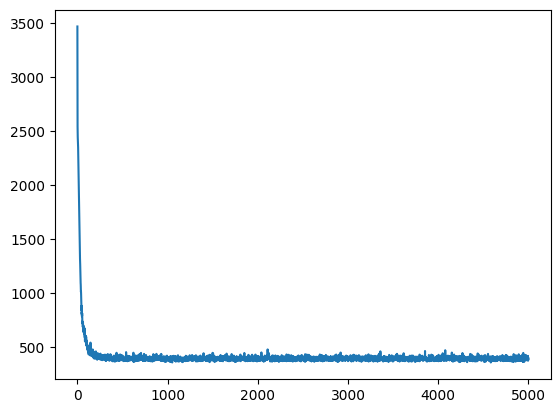

In [313]:
plt.plot(_[2])

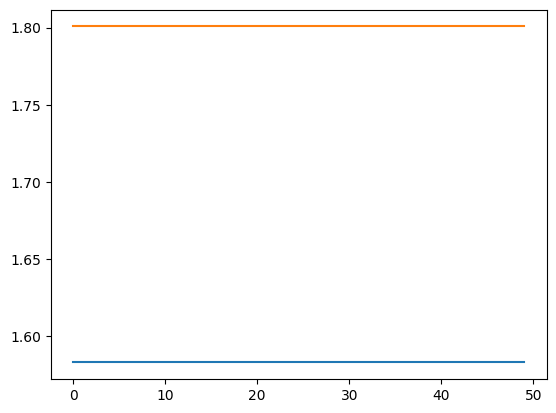

In [314]:
for i in range(num_experts):
    plt.plot(samples_tst["w"].mean(0)[i,:])

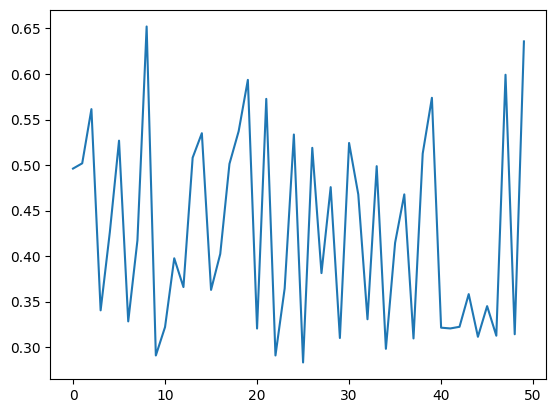

In [315]:
plt.plot(samples_tst["std_fused"].mean(0))

## averaging results

In [140]:
num_experts = 5
num_spectral_freqs = 100
model = pogpe_with_projs
proj_dim = 5

nlpd = []
rmse = []

for split in tqdm(range(10)):

    X_train,y_train,X_test,y_test,_ = load_data(dataset_name,split)

    # map estimates
    nlpd_test, rmse_test, nlpd_train, rmse_train, samples_tst, samples_tr,_ = train_and_predict_joint(
        model=model, num_experts=num_experts, num_spectral_freqs=num_spectral_freqs, 
        data_dict={"X_train": X_train, "y_train": y_train, "X_test": X_test, "y_test": y_test},
        training_iter=500, lr= 0.1,
        proj_dim = proj_dim,
    )

    nlpd.append(nlpd_test)
    rmse.append(rmse_test)

nlpd = np.array(nlpd)
rmse = np.array(rmse)

100%|██████████| 10/10 [00:47<00:00,  4.78s/it]
